In [113]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, 
    aes, stat_smooth, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import seaborn as sns
%matplotlib
sns.set_theme()

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [54]:
DATA_PATH = "../data/"
df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[(df['scenario'] == "base") & (df['model'].str.startswith('qwen2.5:'))]
df['model_size'] = df['model'].str.split(':').str[1].str.replace('b', '').astype(float)
df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'chain',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'deviation', 'model_size'],
      dtype='object')

In [133]:
# Resample: calculate mean and std of five samples out of each 10 samples
resampled = pd.concat(
    df.groupby(["model_size", "chain"]).sample(frac=0.5, random_state=i).groupby(["model_size", "chain"])[["can_answer", "correct", 'execution_time']].mean(numeric_only=True)
    for i in range(10)
).reset_index()
resampled

,model_size,chain,can_answer,correct,execution_time
0,0.5,codegen,0.066667,0.141667,0.742797
1,0.5,direct,0.391667,0.116667,0.296100
2,1.5,codegen,0.683333,0.141667,0.516078
3,1.5,direct,0.750000,0.116667,0.327702
4,3.0,codegen,0.250000,0.116667,5.969625
...,...,...,...,...,...
135,14.0,direct,0.841667,0.558333,2.346137
136,32.0,codegen,0.891667,0.708333,2.940970
137,32.0,direct,0.891667,0.658333,1.849454
138,72.0,codegen,0.466667,0.475000,23.589885


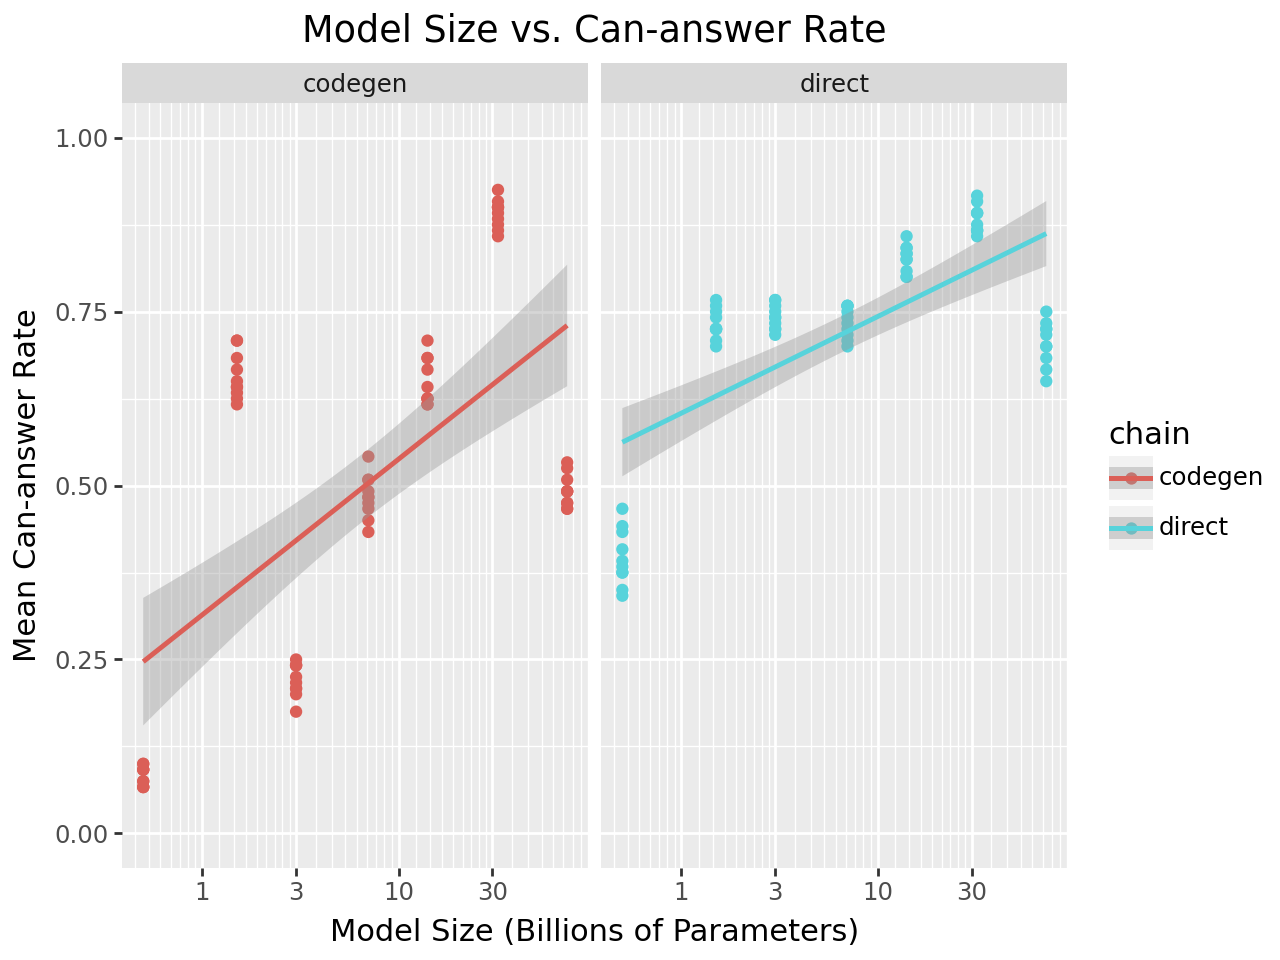

In [134]:
# Model size vs. can_answer
_data = df.groupby(["model_size", "chain"])[['can_answer', 'correct']].mean().reset_index()
# display(_data)
# sns.relplot(data=_data, x='model_size', y='correct', hue='chain')
(
    ggplot(
        resampled,
        aes(x='model_size', y='can_answer', color='chain'),
    ) +
    geom_point() +
    stat_smooth(method='lm') +
    labs(title='Model Size vs. Can-answer Rate', x='Model Size (Billions of Parameters)', y='Mean Can-answer Rate') +
    scale_x_log10() +
    scale_y_continuous(limits=(0, 1)) +
    facet_wrap('~chain', ncol=2)
)


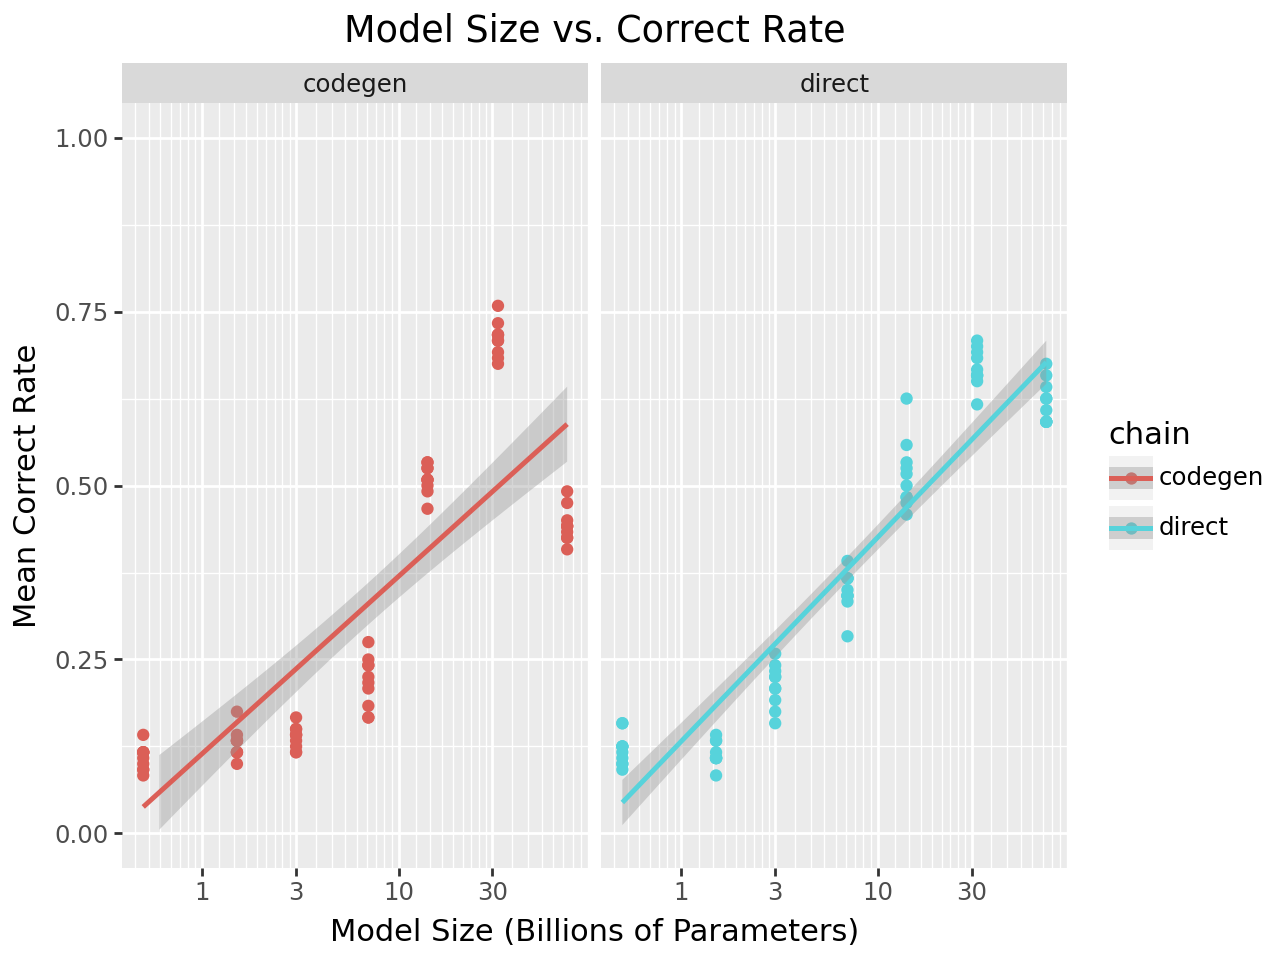

In [135]:
# Model size vs. correct
_data = df.groupby(["model_size", "chain"])['correct'].mean().reset_index()
# display(_data)
(
    ggplot(
        resampled,
        aes(x='model_size', y='correct', color='chain'),
    ) +
    geom_point() +
    stat_smooth(method='lm') +
    labs(title='Model Size vs. Correct Rate', x='Model Size (Billions of Parameters)', y='Mean Correct Rate') +
    scale_x_log10() +
    scale_y_continuous(limits=(0, 1)) +
    facet_wrap('~chain', ncol=2)
)

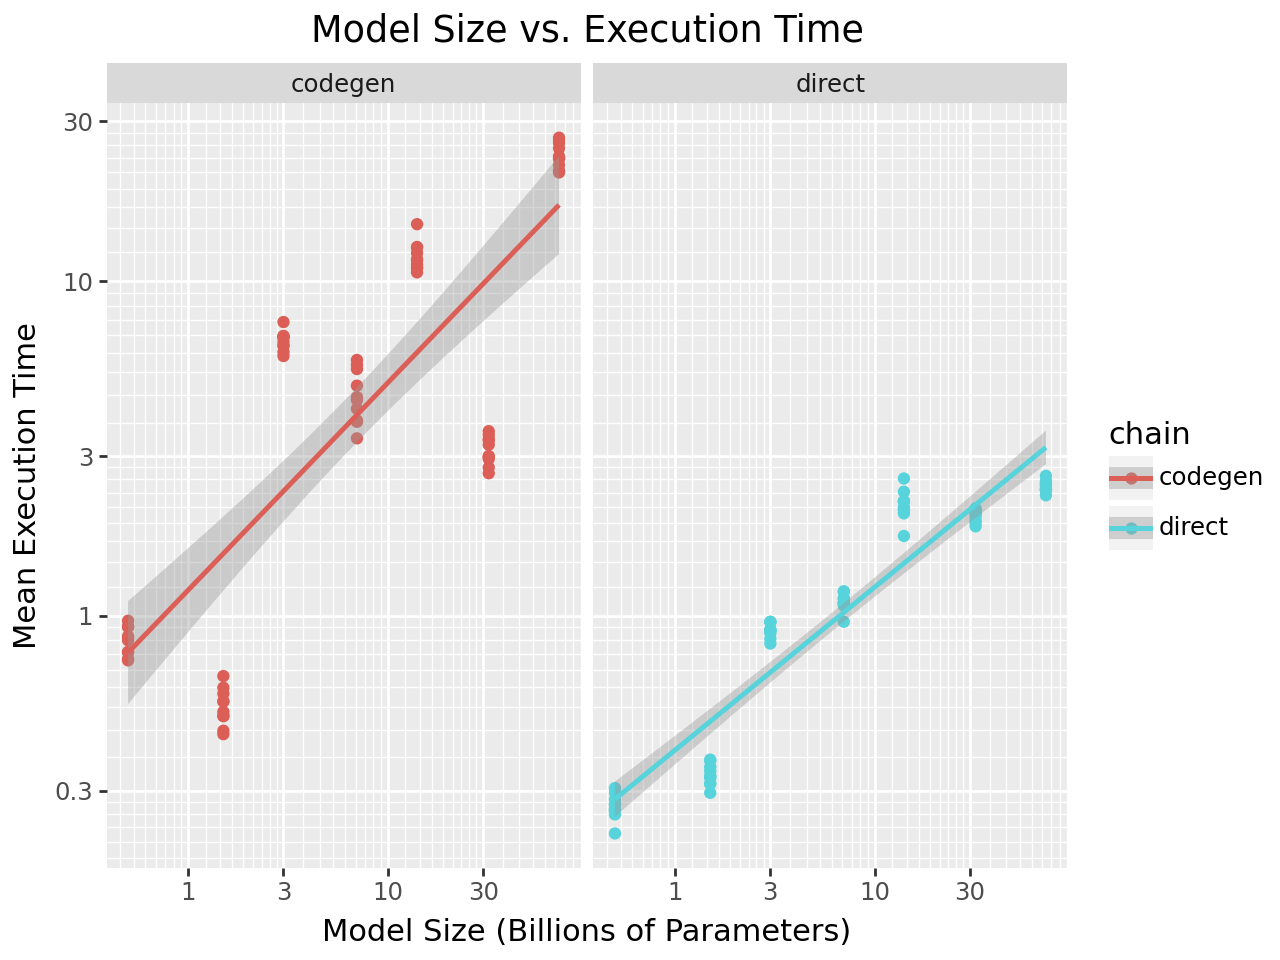

In [136]:
# Model size vs. execution time
(
    ggplot(
        resampled,
        aes(x='model_size', y='execution_time', color='chain'),
    ) +
    geom_point() +
    stat_smooth(method='lm') +
    labs(title='Model Size vs. Execution Time', x='Model Size (Billions of Parameters)', y='Mean Execution Time') +
    scale_x_log10() +
    scale_y_log10() +
    facet_wrap('~chain', ncol=2)
)

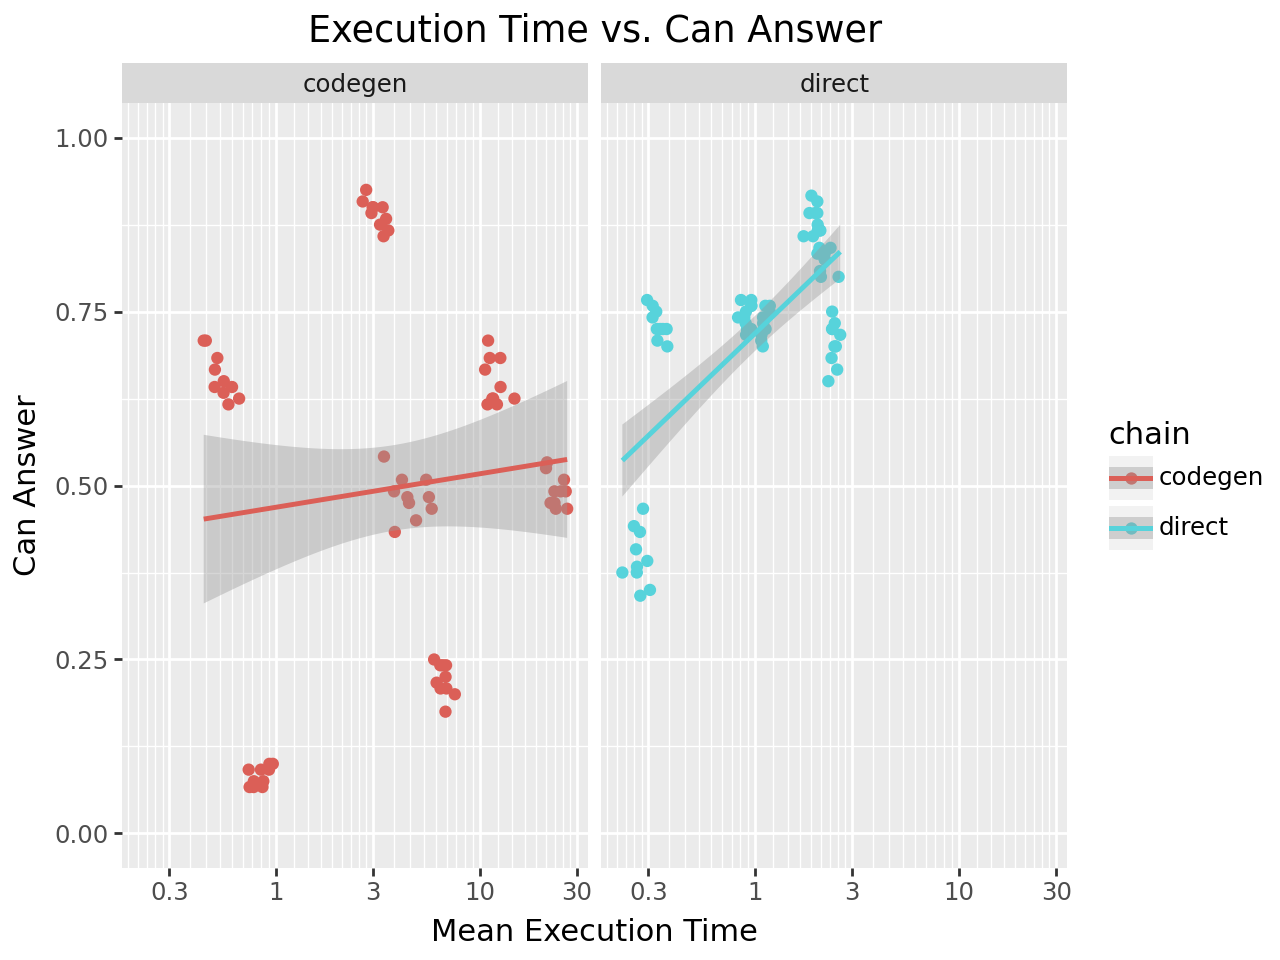

In [137]:
# Execution time vs. can_answer
(
    ggplot(
        resampled,
        aes(x='execution_time', y='can_answer', color='chain'),
    ) +
    geom_point() +
    stat_smooth(method='lm') +
    labs(title='Execution Time vs. Can Answer', x='Mean Execution Time', y='Can Answer') +
    # scale_x_log10() +
    scale_y_continuous(limits=(0, 1)) +
    scale_x_log10() +
    facet_wrap('~chain', ncol=2)
)

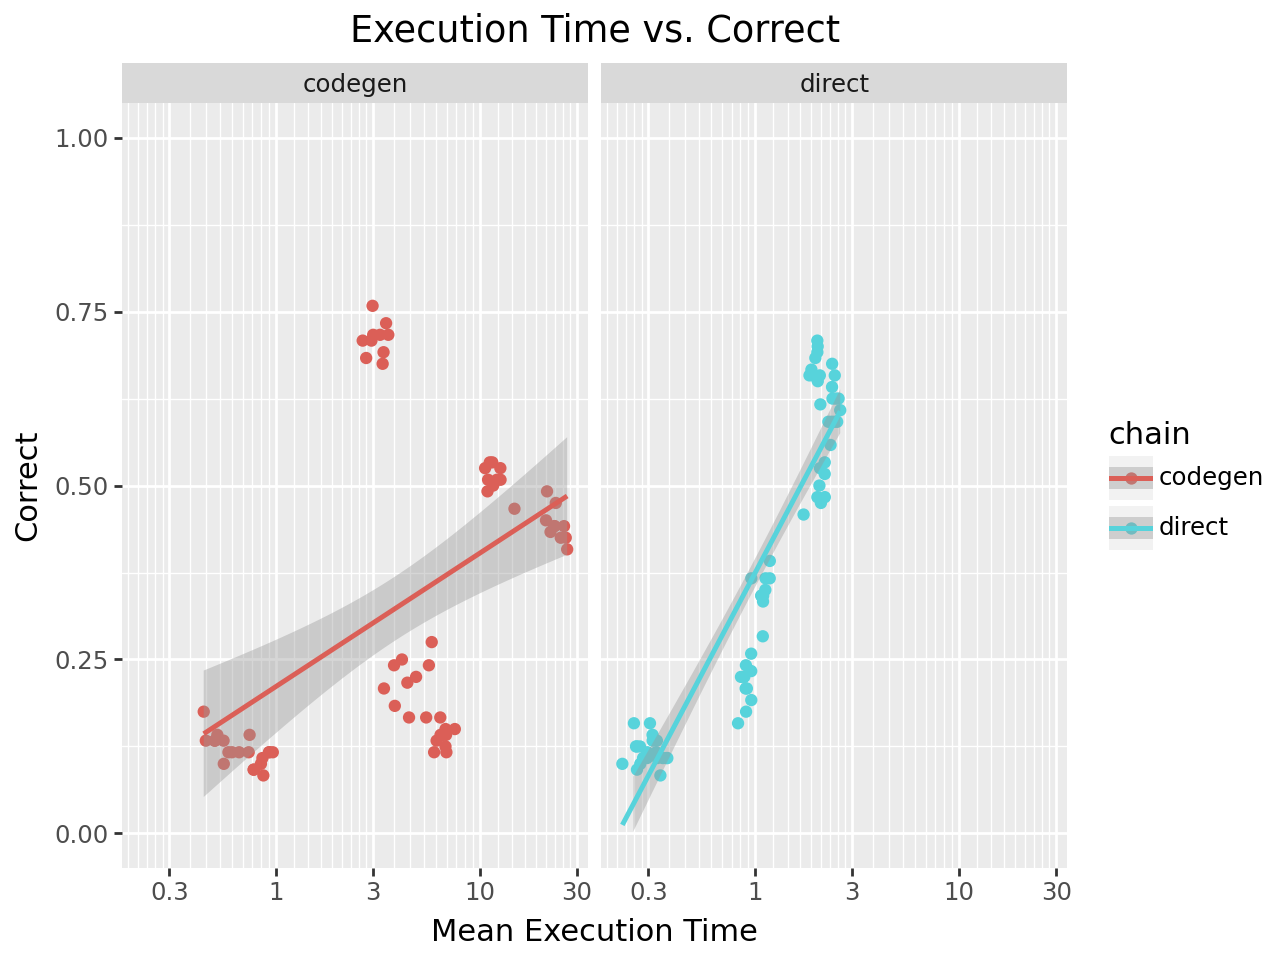

In [138]:
# Execution time vs. correct
(
    ggplot(
        resampled,
        aes(x='execution_time', y='correct', color='chain'),
    ) +
    geom_point() +
    stat_smooth(method='lm') +
    labs(title='Execution Time vs. Correct', x='Mean Execution Time', y='Correct') +
    # scale_x_log10() +
    scale_y_continuous(limits=(0, 1)) +
    scale_x_log10() +
    facet_wrap('~chain', ncol=2)
)

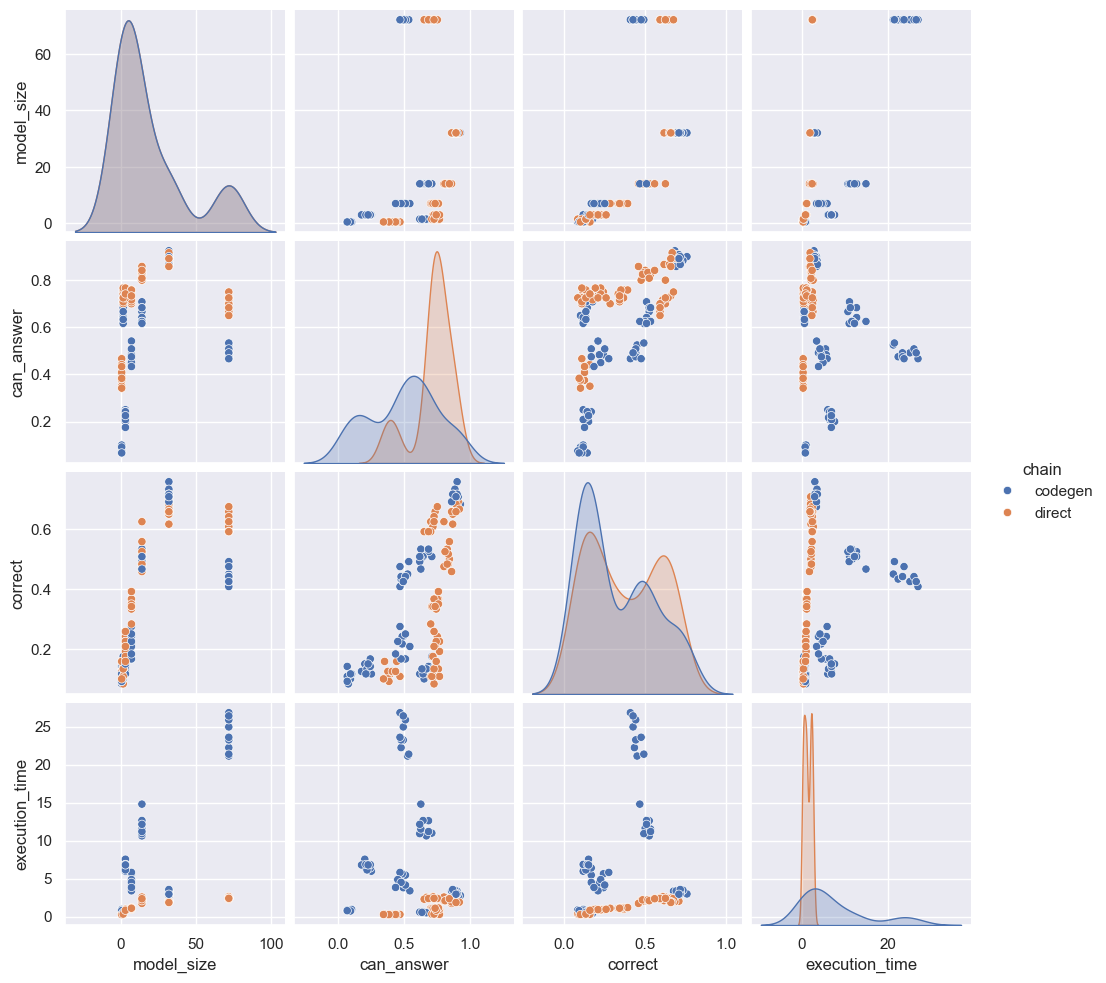

In [139]:
sns.pairplot(resampled, hue='chain', vars=['model_size', 'can_answer', 'correct', 'execution_time'], diag_kind='kde')